In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from galaxy_generator import get_galaxy_rng_vals, get_augmentation_rng_vals, simulate_perfect_galaxy, add_source_to_image, sky_noise
from photutils.aperture import CircularAperture, ApertureStats

Generate an array of galaxy & image properties:

In [5]:
N = 5

# ## Range of values to try
# lims = {
#     'mag' : (12, 18),
#     'sky_mag' : (20, 26),
#     'n_clumps' : (5, 30),
# #     'psf_fwhm' : (0.2, 3),
#     'sersic_n' : (1, 4),
#     'px' : (0.1, 1.0),
# }

# # Generate parameters for n galaxies
# mags = stats.uniform.rvs(loc=lims['mag'][0], scale=lims['mag'][1] - lims['mag'][0], size=N)
# ns = stats.uniform.rvs(loc=lims['sersic_n'][0], scale=lims['sersic_n'][1] - lims['sersic_n'][0], size=N)
# sky_mags = stats.uniform.rvs(loc=lims['sky_mag'][0], scale=lims['sky_mag'][1] - lims['sky_mag'][0], size=N)
# n_clumps = np.random.randint(low=lims['n_clumps'][0], high=lims['n_clumps'][1], size=N)
# psfs = stats.uniform.rvs(loc=lims['psf_fwhm'][0], scale=lims['psf_fwhm'][1] - lims['psf_fwhm'][0], size=N)
# pxscales = stats.uniform.rvs(loc=lims['px'][0], scale=lims['px'][1] - lims['px'][0], size=N)
# psfs = 3*pxscales
# for i in range(N):
#     pxscales[i] = np.min([pxscales[i], psfs[i]/2])
    
# qs = stats.uniform.rvs(loc=0.2, scale=0.8, size=N)
# qs[ns > 3.5] = 1.0
# rs = -1.9*mags + 35 + stats.norm.rvs(loc=0, scale=1.5, size=N)
# rs[rs <= 1] = 1
# rs[rs >= 20] = 20
N = 5
gal_params = get_galaxy_rng_vals(N)
img_params = get_augmentation_rng_vals(N)
for p in img_params:
        p['psf_fwhm'] = 3*p['pxscale']

Generate a perfect and noisy galaxy pair:

In [56]:
def single_galaxy_run(gal_params, img_params, perfect_pxscale=0.1):

    ##### Generate the perfect galaxy image at desired pixelscale
    # Generate galaxy model. r_pet is in ARCSEC.
    image_perfect, galaxy_dict, r_pet = simulate_perfect_galaxy(pxscale=perfect_pxscale,  **gal_params)
    # Convolve with a PSF to make the "perfect" image nyquist-sampled
    image_perfect = add_source_to_image(**galaxy_dict, psf_fwhm=3*perfect_pxscale, pxscale=perfect_pxscale, psf_method='astropy')
    
    # Generate the perfect galaxy at new pixelscale
    image_lowres, galaxy_dict, r_pet = simulate_perfect_galaxy(**img_params, **gal_params)
    
    # Create observed image
    image_psf = add_source_to_image(**galaxy_dict, **img_params, psf_method='astropy')
    image_noisy, sky_flux = sky_noise(np.abs(image_psf), **img_params, rms_noise=True)
    pxscale = img_params['pxscale']
    
    # Calculate noise level
    err = np.sqrt(image_psf + sky_flux**2)
    
    # Calculate average SNR in the aperture
#     snr = image_lowres / err
    xc, yc = image_psf.shape[1]/2, image_psf.shape[0]/2
    ap = CircularAperture((xc,yc), 1.5*r_pet/pxscale)
    avg_snr = ApertureStats(image_psf/err, ap).mean
    
    return image_perfect, image_noisy, avg_snr



Generate `N` galaxies:

In [57]:
perfects = []
noisies = []
snrs = []

for n in range(N):
    
    perfect, noisy, snr = single_galaxy_run(gal_params[n], img_params[n])
    perfects.append(perfect)
    noisies.append(noisy)
    snrs.append(snr)

Plot them:

In [58]:
s=7.5

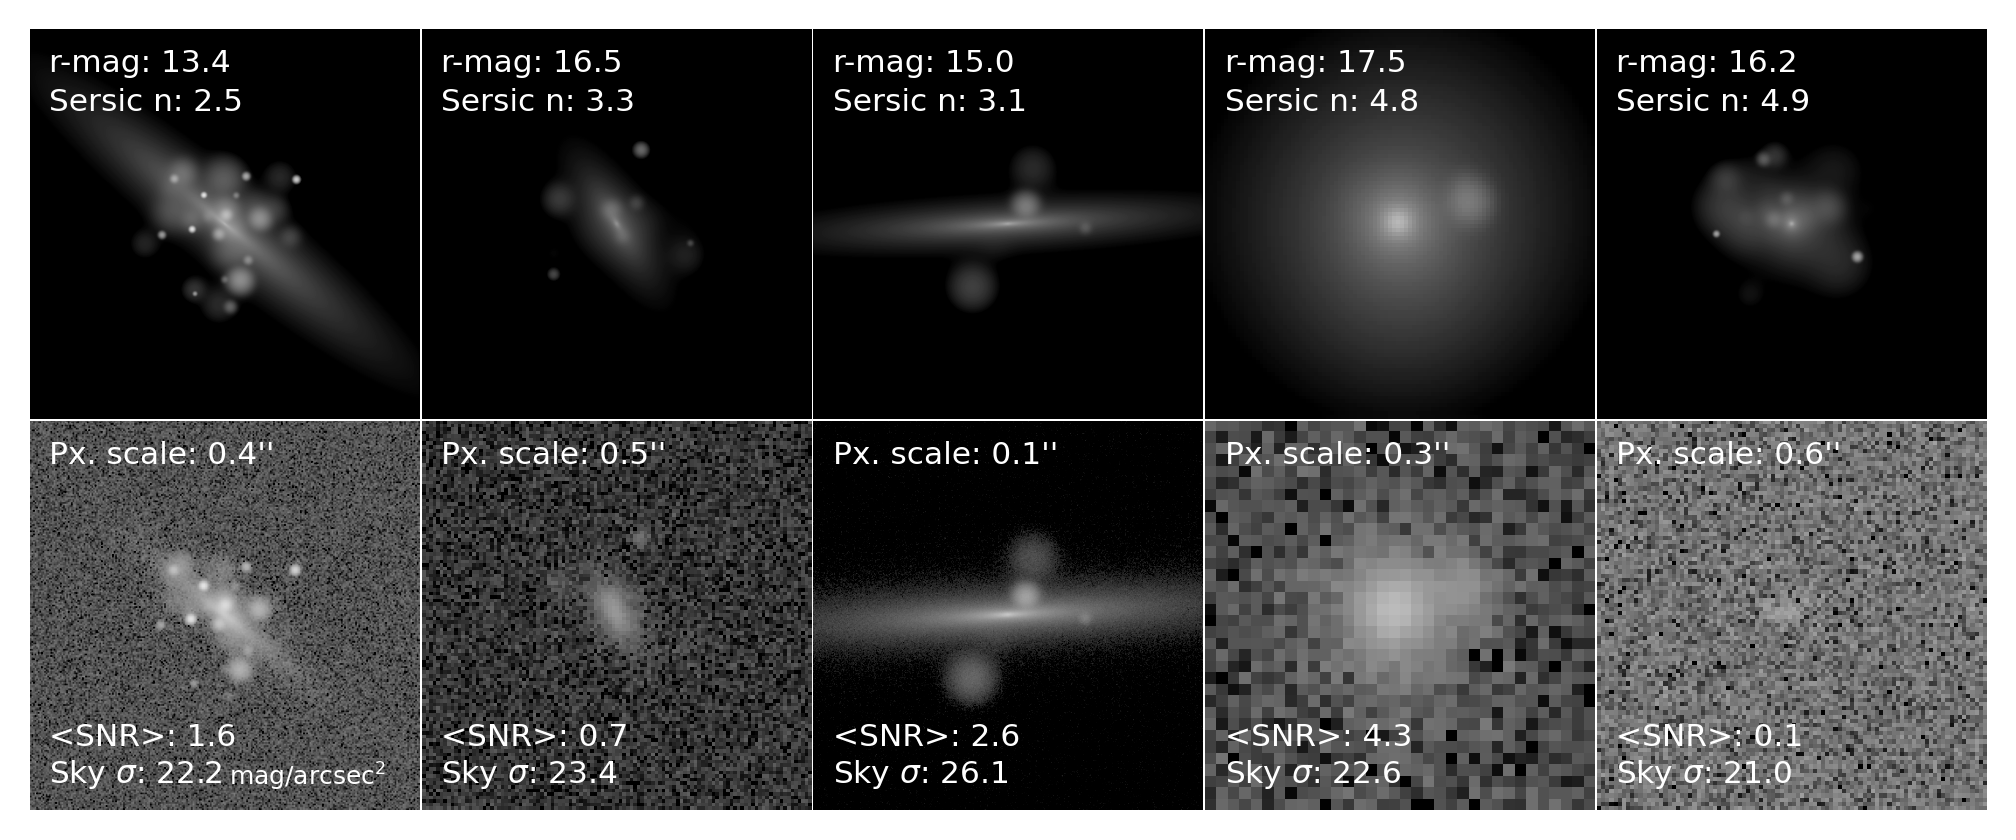

In [59]:
# fig, axs = plt.subplots(2,5,figsize=(15.5,6.1), dpi=100)
fig, axs = plt.subplots(2,5,figsize=(8.415,3.38), dpi=300)

for i in range(N):
    axs[0,i].imshow(-2.5*np.log10(np.abs(perfects[i])/0.1**2) + 33, vmin=17, vmax=27, cmap='gray_r')
    axs[1,i].imshow(-2.5*np.log10(np.abs(noisies[i])/(img_params[i]['pxscale']/2)**2) + 33, vmin=17, vmax=27, cmap='gray_r')
    
    axs[0,i].annotate(f'r-mag: {gal_params[i]["mag"]:0.1f}', xy=(0.05,0.95), xycoords='axes fraction', size=s, color='w', va='top', ha='left')
    axs[0,i].annotate(f'Sersic n: {gal_params[i]["sersic_n"]:0.1f}', xy=(0.05,0.85), xycoords='axes fraction', size=s, color='w', va='top', ha='left')
#     axs[1,i].annotate(f'PSF FWHM: {psfs[i]:0.1f}\'\'', xy=(0.05,0.95), xycoords='axes fraction', size=10, color='w', va='top', ha='left')
    axs[1,i].annotate(f'Px. scale: {img_params[i]["pxscale"]:0.1f}\'\'', xy=(0.05,0.95), xycoords='axes fraction', size=s, color='w', va='top', ha='left')
    axs[1,i].annotate(fr'Sky $\sigma$: {img_params[i]["sky_mag"]:0.1f}', xy=(0.05,0.05), xycoords='axes fraction', size=s, color='w', va='bottom', ha='left')
    axs[1,i].annotate(fr'<SNR>: {snrs[i]:0.1f}', xy=(0.05,0.15), xycoords='axes fraction', size=s, color='w', va='bottom', ha='left')
    
axs[1,0].annotate(fr'mag/arcsec$^2$', xy=(0.51,0.045), xycoords='axes fraction', size=6, color='w', va='bottom', ha='left')
plt.subplots_adjust(wspace=0.005, hspace=0.005)
for ax in axs.flatten():
    ax.axis('off')
#     
# plt.savefig('galsim.pdf', bbox_inches='tight', pad_inches=0)

In [88]:
8.5/(5+0.01*4) * (2+0.01)

3.389880952380952

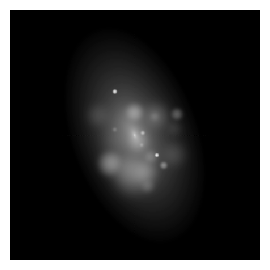

In [5]:
perfect_pxscale = 0.168
seed = 48

params = get_galaxy_rng_vals(1, perfect_pxscale=perfect_pxscale, seed=seed)[0]
img, galaxy_dict, r_pet = simulate_perfect_galaxy(pxscale=perfect_pxscale,  **params)

plt.imshow(-2.5*np.log10(img_perfect/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
plt.axis('off');

In [ ]:
xc, y